In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt


In [2]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    if v3==0:
        mq1=chi[0]/(zeta*zh*ui)
    else:
        #second-order approximation
       mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [3]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_array):
    
#     d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/100
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/20,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>150)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    if mq_array[-1]-mq_array[-2]>5:
        #create an array of 10 new d0 values evenly spaced between the last two d0 values, that doesn't include either of the last two d0 values
        d0_new=np.linspace(d0_array[-2],d0_array[-1],10)[1:-1]
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array between the last two mq values, same for d0
        mq_array=np.concatenate((mq_array[:-1],mq_new,mq_array[-1:]))
        d0_array=np.concatenate((d0_array[:-1],d0_new,d0_array[-1:]))
    return d0_array,mq_array

# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
# T=1
# mu=0
# mq_large=15
# lambda1=5.7
# ui=1e-4
# uf=1-ui
# numpoints=100
# d0_lower=70
# d0_upper=88
# d0_array=np.linspace(d0_lower,d0_upper,numpoints)
# d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# d0_old=d0_array
# d0_min=d0_array[np.abs(mq_array)>1e-3][0]
# mq_array=mq_array[d0_array>d0_min]
# d0_array=d0_array[d0_array>d0_min]
# # it seems that the first two points are identical, so remove one
# d0_array=d0_array[1:]
# mq_array=mq_array[1:]
# "This works, but makes WAY too many points"
# # smallest_diff=np.min(np.gradient(d0_array))

# # d0_array=np.arange(d0_array[0],d0_array[-1]+smallest_diff,smallest_diff)

# # d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

# # solving from IR again to retain the function chi and its derivative chip for each value of d0
# _,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

# #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
# i=10
# u=np.linspace(ui,uf,len(chips[0]))
# u_int=u[i]
# chi0=chis[:,i]
# chip0=chips[:,i]

# #solving for mq and sigma
# lambda3=v3
# zeta=np.sqrt(3)/(2*np.pi)
# zh,q=blackness(T,mu)
# # if lambda3 is nonzero, calculate mq and sigma using the improved formula
# # if lambda3 is zero, calculate mq and sigma using the round formula
# if lambda3==0:
#     sigma_improved=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
#     mq_improved=mq_array#chi0/(zeta*zh*u_int)
# else:
#     mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
#     sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)



In [4]:
# The function that will run in parallel
def process_mq_target(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3):
    # Your additional function calls like chiral_solve_IR, blackness go here
    
    d0_list = d0_array.tolist()
    mq_list = mq_improved.tolist()
    sigma_list = sigma_improved.tolist()
    
    indices = np.where(np.diff(np.sign(mq_improved - mq_target)))[0]
    
    results = []
    for index in indices:
        mq_approx = np.array([mq_improved[index], mq_improved[index + 1]])
        d0_approx = np.array([d0_array[index], d0_array[index + 1]])
        
        d0_interp = interp1d(mq_approx, d0_approx)
        d0 = d0_interp(mq_target)
        mq,chi,chip,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)
#         print(mq)
        #picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
        i=10
        u=np.linspace(ui,uf,len(chip))
        u_int=u[i]
        chi0=chi[i]
        chip0=chip[i]

        #solving for mq and sigma
        lambda3=v3
        zeta=np.sqrt(3)/(2*np.pi)
        zh,q=blackness(T,mu)
        # if lambda3 is nonzero, calculate mq and sigma using the improved formula
        # if lambda3 is zero, calculate mq and sigma using the round formula
        if lambda3==0:
            sigma_new=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)
            mq_new=mq#chi0/(zeta*zh*u_int)
        else:
            mq_new=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
            sigma_new=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
            sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
            # sigma_improved=sigma_approx
#         print("d0=",d0)
        
        d0_list.append(d0)
        mq_list.append(mq_new)
        sigma_list.append(sigma_new)
        
    return np.array(d0_list), np.array(mq_list), np.array(sigma_list)

# # Main code
# numMass = 100
# mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)

# results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

# # Aggregate results
# all_d0_arrays = [res[0] for res in results]
# all_mq_improved = [res[1] for res in results]
# all_sigma_improved = [res[2] for res in results]

# # Concatenating all the arrays
# all_d0_array = np.concatenate(all_d0_arrays)
# all_mq_improved = np.concatenate(all_mq_improved)
# all_sigma_improved = np.concatenate(all_sigma_improved)

# # Sorting by d0_array
# sort_indices = np.argsort(all_d0_array)
# all_d0_array = all_d0_array[sort_indices]
# all_mq_improved = all_mq_improved[sort_indices]
# all_sigma_improved = all_sigma_improved[sort_indices]

# # Removing duplicate d0 values
# unique_indices = np.unique(all_d0_array, return_index=True)[1]
# final_d0_array = all_d0_array[unique_indices]
# mq_improved = all_mq_improved[unique_indices]
# sigma_improved = all_sigma_improved[unique_indices]




In [5]:

def new_function(lambda1, T, mu, mq_large, ui, uf, d0_lower, d0_upper, numpoints=100):
    # Initial d0 and mq arrays
    d0_array = np.linspace(d0_lower, d0_upper, numpoints)
    d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_array)

    # Further processing to get mq_improved and sigma_improved
    _, chis, chips = chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)  # Assuming this function exists

    i = 10
    u = np.linspace(ui, uf, len(chips[0]))
    u_int = u[i]
    chi0 = chis[:, i]
    chip0 = chips[:, i]

    lambda3 = v3  
    zeta = np.sqrt(3) / (2 * np.pi)
    zh, q = blackness(T, mu)  
    
    if lambda3 == 0:
        sigma_improved = zeta * (chip0 * u_int - chi0) / (2 * u_int ** 3 * zh ** 3)
        mq_improved = mq_array
    else:
        mq_improved =(1 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * lambda3 * zeta * u_int * zh)
        sigma_improved = zeta * (1 - 6 * chi0 * lambda3 + 3 * chip0 * u_int * lambda3 - np.sqrt(1 - 3 * lambda3 * (3 * chi0 - chip0 * u_int))) / (3 * u_int ** 3 * zh ** 3 * lambda3)
        sigma_approx = zeta/(3*u_int**3*zh**3*lambda3)*(2*chip0*u_int-3/2*chi0)
        # sigma_improved = sigma_approx

    # Run process_mq_target in parallel
    numMass = 100
    mq_overlay = np.linspace(np.min(mq_improved), mq_large, numMass)
    results = Parallel(n_jobs=-1)(delayed(process_mq_target)(mq_target, d0_array, mq_improved, sigma_improved, lambda1, T, mu, ui, uf, v3) for mq_target in mq_overlay)

    # Aggregate and sort results
    all_d0_arrays = [res[0] for res in results]
    all_mq_improved = [res[1] for res in results]
    all_sigma_improved = [res[2] for res in results]
    
    all_d0_array = np.concatenate(all_d0_arrays)
    all_mq_improved = np.concatenate(all_mq_improved)
    all_sigma_improved = np.concatenate(all_sigma_improved)

    sort_indices = np.argsort(all_d0_array)
    all_d0_array = all_d0_array[sort_indices]
    all_mq_improved = all_mq_improved[sort_indices]
    all_sigma_improved = all_sigma_improved[sort_indices]

    unique_indices = np.unique(all_d0_array, return_index=True)[1]
    final_d0_array = all_d0_array[unique_indices]
    mq_improved = all_mq_improved[unique_indices]
    sigma_improved = all_sigma_improved[unique_indices]

    return mq_improved, sigma_improved, final_d0_array

# Note: The function uses variables like v3, chiral_solve_IR_parallel, blackness which should already be defined in your context.




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_60828/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)
/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_60828/2714060108.py:12: RuntimeWarning: invalid value encountered in power
  plt.plot(mq_improved,sigma_improved**(1/3),'.')


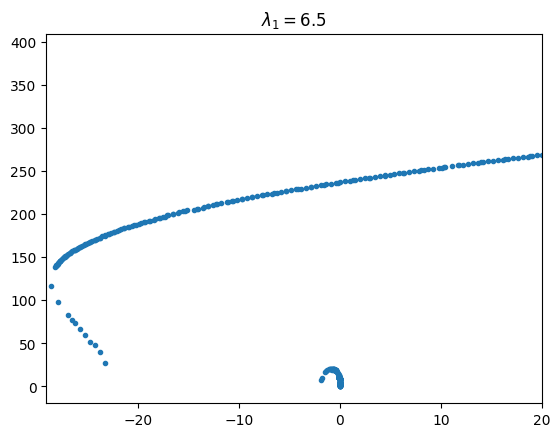

In [6]:
lambda1=6.5
T=5
mu=0
mq_large=20
ui=1e-4
uf=1-ui
d0_lower=0
d0_upper=40

mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)

plt.plot(mq_improved,sigma_improved,'.')
plt.xlim([min(mq_improved)-.5,20])
#make the ylimits from 0 to the value of sigma improved at approximately mq=20 (there may not be a value of sigma_improved at exactly mq=20)
# plt.ylim([0,sigma_improved[np.where(mq_improved>20)[0][0]]/1e9])
# plt.ylim([0,np.max(sigma_improved)/1e9])
plt.title('$\lambda_1=$'+str(lambda1))
plt.show()

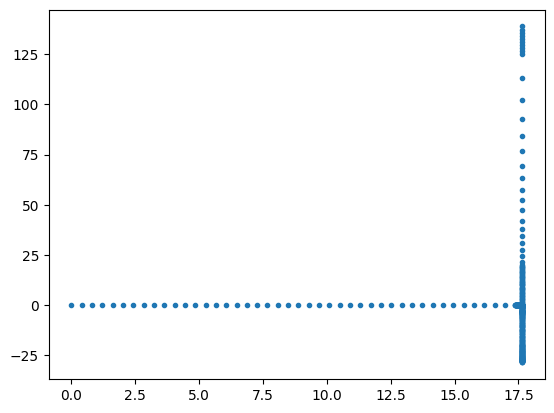

In [7]:
plt.plot(d0_array,mq_improved,'.')
plt.show()

In [7]:
# the quark mass I want to use
mq_input=9 
mq_tolerance=0.01
# find the indices where mq_improved-mq_input changes sign
indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
# for each element in indices
# if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
# if not, interpolate between the two surrounding vlales of d0_array
sigma_list=[]
for index in indices:
    if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index]
    elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
        sigma_input=sigma_improved[index+1]
    else:
        sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
        sigma_input=sigma_interp(mq_input)
    sigma_list.append(sigma_input)
#make sigma_list into an array
sigma_values=np.array(sigma_list)
print('sigma_input^1/3=',(sigma_values)**(1/3))

NameError: name 'mq_improved' is not defined

In [6]:
def sigma_of_T(mq_input,mq_tolerance,T,mu,lambda1,d0_lower,d0_upper,ui):
    uf=1-ui
    mq_large=2*mq_input
    mq_improved,sigma_improved, d0_array=new_function(lambda1,T,mu,mq_large,ui,uf,d0_lower,d0_upper,numpoints=100)
    # find the indices where mq_improved-mq_input changes sign
    indices=np.where(np.diff(np.sign(mq_improved-mq_input)))[0]
    # for each element in indices
    # if one of the surrounding values of mq_improved is within mq_tolerance of mq_input, then use that value of sigma_improved
    # if not, interpolate between the two surrounding vlales of d0_array
    sigma_list=[]
    for index in indices:
        if np.abs(mq_improved[index]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index]
        elif np.abs(mq_improved[index+1]-mq_input)<mq_tolerance:
            sigma_input=sigma_improved[index+1]
        else:
            sigma_interp=interp1d(mq_improved[index:index+2],sigma_improved[index:index+2])
            sigma_input=sigma_interp(mq_input)
        sigma_list.append(sigma_input)
    #make sigma_list into an array
    sigma_values=np.array(sigma_list)
    #if sigma_values has less than three elements, pad with zeros
    if len(sigma_values)<3:
        sigma_values=np.pad(sigma_values,(0,3-len(sigma_values)),'constant')

    return sigma_values,np.max(d0_array),np.min(d0_array)

In [34]:
def sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps):
    T_array=np.linspace(tmin,tmax,numtemps)
    # if tmin<20:
    #     d0_upper=50
    # else:
    #     d0_upper=10
    d0_upper=10
    d0_lower=0
    # create a numpy array of zeros with 3 by numtemps elements to store the sigma values
    sigma_array=np.zeros((3,numtemps))
    for i in range(numtemps):
        try:
            ui=1e-2
            sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
        except:
            ui=1e-4
            sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
        # every 10 iterations, print the temperature
        if i%10==0:
            print("Temperature is ", T_array[i])
        d0_upper=d0_max
        d0_lower=max(0,d0_min/2)
    return sigma_array
    


In [35]:
tmin=15
tmax=95
numtemps=100

lambda1=5.3
mq_input=9
mq_tolerance=0.1
mu=215

sigma_array = sigma_temp_scan(mq_input,mq_tolerance,lambda1,mu,tmin,tmax,numtemps)

# T_array=np.linspace(tmin,tmax,numtemps)
# # if tmin<20:
# #     d0_upper=50
# # else:
# #     d0_upper=10
# d0_upper=10
# d0_lower=0


# # create a numpy array of zeros with 3 by numtemps elements to store the sigma values
# sigma_array=np.zeros((3,numtemps))
# for i in range(numtemps):
#     try:
#         ui=1e-2
#         sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
#     except:
#         ui=1e-4
#         sigma_array[:,i],d0_max,d0_min=sigma_of_T(mq_input,mq_tolerance,T_array[i],mu,lambda1,d0_lower,d0_upper,ui)
#     # every 10 iterations, print the temperature
#     if i%10==0:
#         print("Temperature is ", T_array[i])
#     d0_upper=d0_max
#     d0_lower=max(0,d0_min/2)
    




/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_63263/1446935064.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


Temperature is  15.0
Temperature is  23.080808080808083
Temperature is  31.161616161616163
Temperature is  39.24242424242424
Temperature is  47.323232323232325
Temperature is  55.4040404040404
Temperature is  63.484848484848484
Temperature is  71.56565656565657
Temperature is  79.64646464646465
Temperature is  87.72727272727272


In [36]:
import gc

# Your code here

gc.collect()


8009

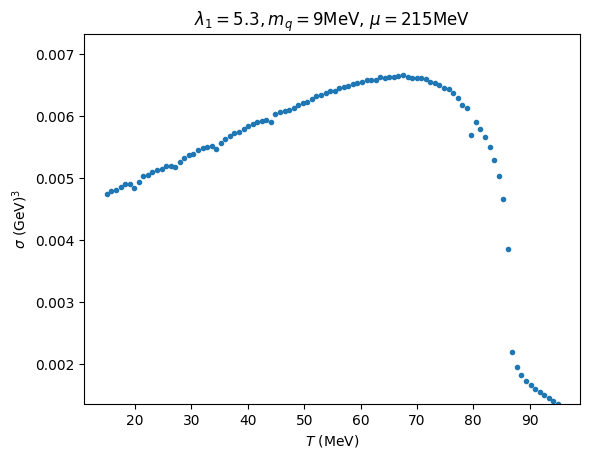

In [37]:
plt.plot(T_array,sigma_array[0,:]/1e9,'.')
plt.plot(T_array,sigma_array[1,:]/1e9,'.')
plt.plot(T_array,sigma_array[2,:]/1e9,'.')
plt.xlabel('$T$ (MeV)')
plt.ylabel('$\sigma$ (GeV)$^3$')
plt.ylim([np.min(sigma_array[0,:]/1e9),1.1*np.max(sigma_array[0,:]/1e9)])
plt.title('$\lambda_1=$'+str(lambda1)+'$, m_q=$'+str(mq_input)+'MeV, $\mu= $'+str(mu)+'MeV')
plt.show()